# Input-Output Decorrelation Analysis

Here you'll find the core analysis code and data supporting our study on how input and output representations in the olfactory bulb are transformed to support odour decorrelation and improved discriminability.

Decorrelation by gain control in the mouse olfactory bulb
([preprint link])

## Setup and Data Loading

In [ ]:
%pylab inline
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import warnings
import random
from scipy.cluster import hierarchy as H
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.metrics import confusion_matrix

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Download Data from Zenodo

**Run this cell once to download the required data files.**

This will download three files from our Zenodo archive:
- `glom_omp_data.h5` (45.4 MB) - OMP+ input layer calcium imaging data
- `glom_tbet_data.h5` (15.6 MB) - Tbet+ output layer calcium imaging data
- `processed_data.h5` (59.6 MB) - Preprocessed and z-scored response data

The files will be verified using MD5 checksums and saved to the `data/` directory.

**Note:** If the files already exist and checksums match, the download will be skipped.

In [ ]:
from pathlib import Path
import hashlib
import requests
import sys
import scipy

# Zenodo record ID
ZENODO_RECORD = "17359151" 

# Files to download with their expected MD5 checksums
FILES = {
    "glom_omp_data.h5":  "md5:decd2aec8b7d7897fe5817f32773e139",   # 45.4 MB - OMP+ input layer data
    "glom_tbet_data.h5": "md5:3f7da2afe521c6f7328a753037872540",   # 15.6 MB - Tbet+ output layer data
    "processed_data.h5": "md5:b346484fbc135aa31b349ea73ac2dad8",   # 59.6 MB - Preprocessed input and output data
}

# Target directory for raw data
target_dir = Path("../data").resolve()
target_dir.mkdir(parents=True, exist_ok=True)

def md5sum(filepath):
    """Calculate MD5 checksum of a file"""
    h = hashlib.md5()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return "md5:" + h.hexdigest()

def download_file(url, dest):
    """Download file with progress indicator"""
    print(f"Downloading {dest.name}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        done = 0
        with open(dest, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024*1024):
                if chunk:
                    f.write(chunk)
                    done += len(chunk)
                    if total:
                        pct = 100 * done / total
                        sys.stdout.write(f"\r  Progress: {pct:.1f}% ({done/1024/1024:.1f}/{total/1024/1024:.1f} MB)")
                        sys.stdout.flush()
    print(" ✓")

print("=" * 60)
print("ZENODO DATA DOWNLOADER")
print("=" * 60)

if ZENODO_RECORD != "17359151":
    print("\n⚠️  WARNING: Zenodo record ID not set!")
    print("   Please update ZENODO_RECORD with the actual record ID")
    print("   after uploading data to Zenodo.")
    print("\n✓ Data files already present - skipping download.\n")
else:
    # Download each file
    for fname, expected_md5 in FILES.items():
        url = f"https://zenodo.org/record/{ZENODO_RECORD}/files/{fname}?download=1"
        dest = target_dir / fname

        # Skip if correct file already present
        if dest.exists():
            try:
                if md5sum(dest) == expected_md5:
                    print(f"✓ {fname} already present and verified.")
                    continue
                else:
                    print(f"⚠️  {fname} present but checksum mismatch; re-downloading.")
                    dest.unlink()
            except Exception as e:
                print(f"⚠️  Could not verify {fname}; re-downloading.")
                dest.unlink()

        # Download the file
        print(f"\nFetching {fname} from Zenodo...")
        download_file(url, dest)

        # Verify checksum
        got_md5 = md5sum(dest)
        if got_md5 != expected_md5:
            raise ValueError(f"❌ Checksum mismatch for {fname}: got {got_md5}, expected {expected_md5}")
        print(f"✓ Verified {fname}")

    print("\n" + "=" * 60)
    print("✓ All data files downloaded and verified!")
    print("=" * 60)

### Load Data from HDF5 Files

In [3]:
# Construct path to processed data file
data_path = '../data/processed_data.h5'
if not os.path.exists(data_path):
    data_path = 'data/processed_data.h5'

if not os.path.exists(data_path):
    print("❌ processed_data.h5 not found!")
    print("\n🔧 To create it, run the cell above (RUN THIS CELL ONCE) or:")
    print("   cd data")
    print("   python save_processed_data.py")
    raise FileNotFoundError(f"Could not find processed_data.h5 at {data_path}")

# Load preprocessed data
print(f"Loading data from: {data_path}")
with h5py.File(data_path, 'r') as f:
    X = f['X'][:]
    Y = f['Y'][:]
    Xt = f['Xt'][:]
    Yt = f['Yt'][:]
    Xtrialz = f['Xtrialz'][:]
    Ytrialz = f['Ytrialz'][:]
    Xtrialzi = f['Xtrialzi'][:]
    Ytrialzi = f['Ytrialzi'][:]
    Xtrialzi_svm = f['Xtrialzi_svm'][:]
    Ytrialzi_svm = f['Ytrialzi_svm'][:]
    
    # Load sliding window data
    X_sliding = f['X_sliding'][:]
    Y_sliding = f['Y_sliding'][:]
    win_title = f['win_title'][:]
    n_wins = f['n_wins'][()]
    win_size = f['win_size'][()]
    
    # Load odour names
    omp_odours = [o.decode('utf-8') for o in f['omp_odours'][:]]
    tbet_odours = [o.decode('utf-8') for o in f['tbet_odours'][:]]
    odour_inds = f['odour_inds'][:]
    
    # Load time axes and odour names dictionary
    omp_time_axis = f['omp_time_axis'][:]
    tbet_time_axis = f['tbet_time_axis'][:]
    odour_names = [o.decode('utf-8') for o in f['odour_names'][:]]

print(f"✓ Loaded X: {X.shape}, Y: {Y.shape}")
print(f"✓ OMP glomeruli: {X.shape[0]}, Odours: {X.shape[1]}")
print(f"✓ Tbet glomeruli: {Y.shape[0]}, Odours: {Y.shape[1]}")
print(f"✓ Sliding window: {n_wins} windows, X_sliding: {X_sliding.shape}, Y_sliding: {Y_sliding.shape}")


Loading data from: ../data/processed_data.h5
✓ Loaded X: (148, 48), Y: (167, 48)
✓ OMP glomeruli: 148, Odours: 48
✓ Tbet glomeruli: 167, Odours: 48
✓ Sliding window: 31 windows, X_sliding: (31, 48, 148), Y_sliding: (31, 48, 167)
✓ Loaded X: (148, 48), Y: (167, 48)
✓ OMP glomeruli: 148, Odours: 48
✓ Tbet glomeruli: 167, Odours: 48
✓ Sliding window: 31 windows, X_sliding: (31, 48, 148), Y_sliding: (31, 48, 167)


## Hierarchical odour clustering

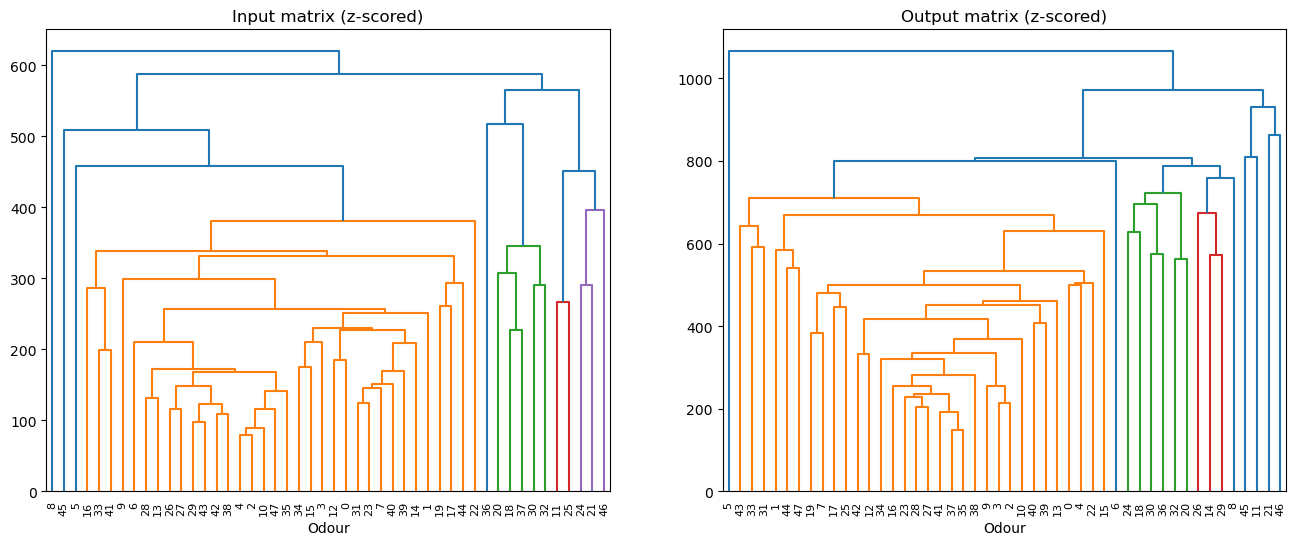

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
Z = H.linkage(X.T, 'weighted', metric= "euclidean", optimal_ordering = True)
H.dendrogram(Z); plt.title('Input matrix (z-scored)'); plt.xlabel('Odour')
olo = H.leaves_list(Z)

plt.subplot(1,2,2)
Z = H.linkage(Y.T, 'weighted', metric= "euclidean", optimal_ordering = True)
H.dendrogram(Z); plt.title('Output matrix (z-scored)'); plt.xlabel('Odour')
plt.show()

---
# Figure 2: Input and output responses reveal structured and diverse odour representations

### Input Layer Timeseries (OMP+)

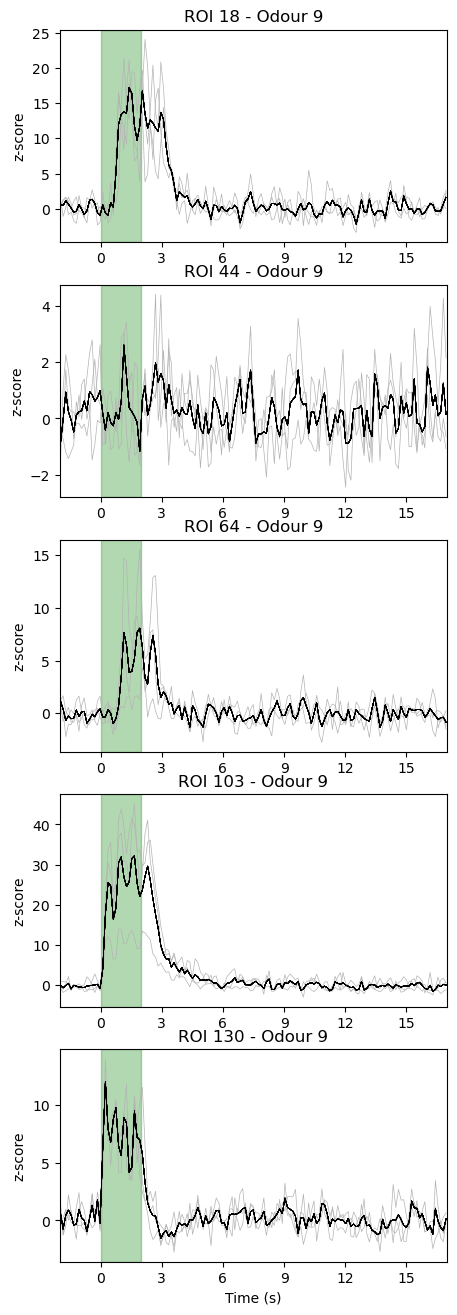

In [ ]:
warnings.filterwarnings('ignore', category=RuntimeWarning)
signal = Xtrialz
time_axis = omp_time_axis - 3
odour_select = 6 
gloms_in = [18,44,64,103,130]

fig,axes = subplots(5,1,figsize=(5,16))
for index,ROI in enumerate(gloms_in):
    for i in range(signal.shape[2]):
        axes[index].plot(time_axis, signal[ROI,olo[odour_select],i,:] - nanmean(signal[ROI,olo[odour_select],i,1:10]), color=[0.7, 0.7, 0.7], lw=0.5);
        ca2mean = nanmean(signal[ROI,olo[odour_select],:,:], axis=0);
        axes[index].plot(time_axis, ca2mean - mean(ca2mean[1:10]), "black", lw=0.5);
        axes[index].set_title(f'ROI {ROI} - Odour {olo[odour_select]}')
        axes[index].set_ylabel('z-score')
        if index == len(gloms_in) - 1:
            axes[index].set_xlabel('Time (s)')
        axes[index].set_xticks(arange(-3, 24, 3))
        axes[index].set_xlim(-2,17)
    axes[index].axvspan(0,2, color='green',alpha=0.3)
plt.show()

### Output Layer Timeseries (Tbet+)

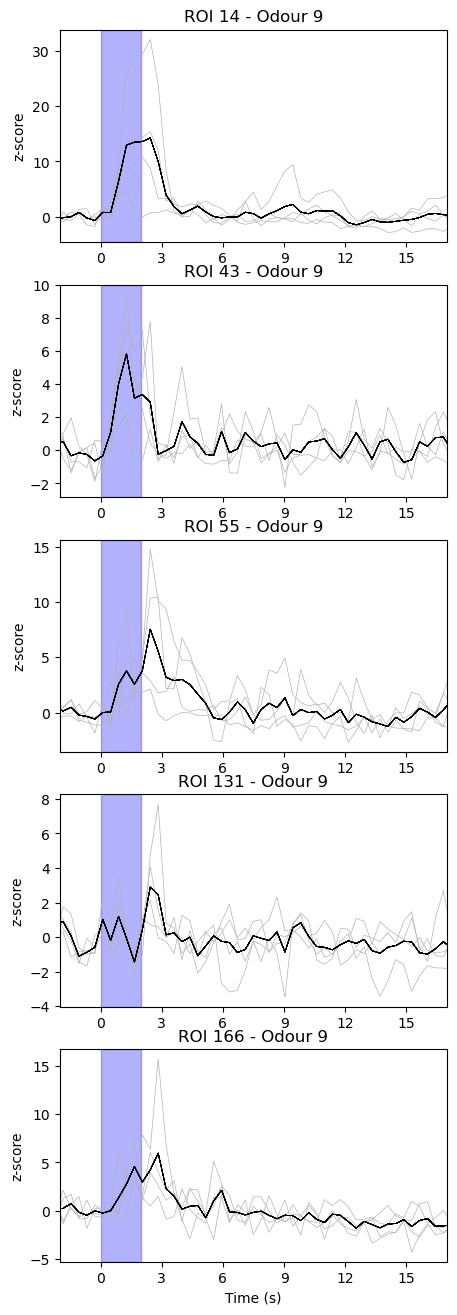

In [12]:
warnings.filterwarnings('ignore', category=RuntimeWarning)
signal = Ytrialz
time_axis = tbet_time_axis - 3
odour_select = 6
gloms_out = [14,43,55,131,166]

fig,axes = subplots(5,1,figsize=(5,16))
for index,ROI in enumerate(gloms_out):
    for i in range(signal.shape[2]):
        axes[index].plot(time_axis, signal[ROI,olo[odour_select],i,:] - nanmean(signal[ROI,olo[odour_select],i,1:10]), color=[0.7, 0.7, 0.7], lw=0.5);
        ca2mean = nanmean(signal[ROI,olo[odour_select],:,:], axis=0);
        axes[index].plot(time_axis, ca2mean - mean(ca2mean[1:10]), "black", lw=0.5);
        axes[index].set_title(f'ROI {ROI} - Odour {olo[odour_select]}')
        axes[index].set_ylabel('z-score')
        if index == len(gloms_out) - 1:
            axes[index].set_xlabel('Time (s)')
        axes[index].set_xticks(arange(-3, 24, 3))
        axes[index].set_xlim(-2,17)
    axes[index].axvspan(0,2, color='blue',alpha=0.3)
plt.show()

### Response Pattern Heatmaps

<Figure size 1000x700 with 0 Axes>

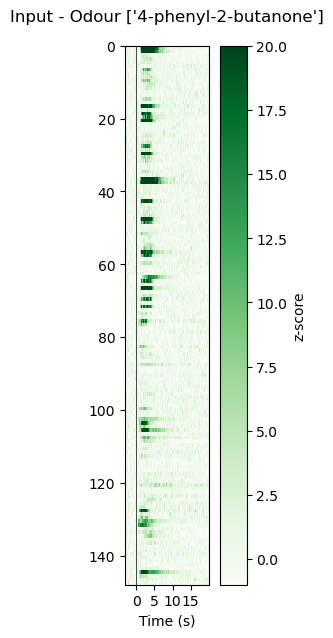

<Figure size 1000x700 with 0 Axes>

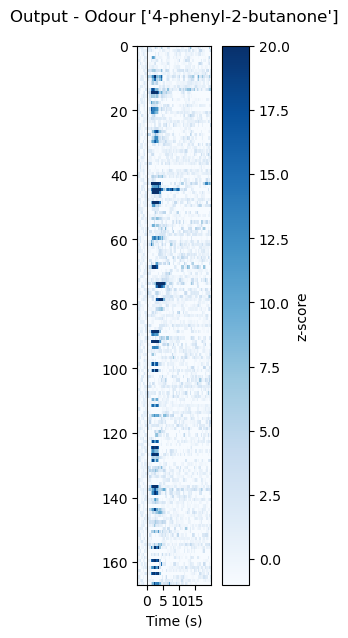

In [ ]:
odour_select = 3

omp_extent = [-3, omp_time_axis[-1], Xt.shape[0], 0]
tbet_extent = [-3, tbet_time_axis[-1], Yt.shape[0], 0]

# from pylab import rcParams
rcParams['figure.figsize'] = 2.8, 7
plt.figure(figsize=(10,7))
fig = plt.figure()
ax = plt.gca()

ax.matshow(Xt[:,olo[odour_select],:],cmap=cm.Greens, extent = omp_extent, vmin=-1, vmax=20); ax.set_title("Input - Odour "+str([odour_names[olo[odour_select]]]), y=1.03); 
ax.set_xlabel('Time (s)'); ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5); ax.xaxis.set_ticks_position('bottom'); 
ax=plt.gca() #get the current axes
for PCM in ax.get_children():
    if isinstance(PCM, mpl.cm.ScalarMappable):
        break
cbar = plt.colorbar(PCM, ax=ax)
cbar.set_label('z-score')
plt.show()

rcParams['figure.figsize'] = 2.8, 7
plt.figure(figsize=(10,7))
fig = plt.figure()
ax = plt.gca()

ax.matshow(Yt[:,olo[odour_select],:],cmap=cm.Blues, extent = tbet_extent, vmin=-1, vmax=20); ax.set_title("Output - Odour "+str([odour_names[olo[odour_select]]]), y=1.03); 
ax.set_xlabel('Time (s)'); ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5); ax.xaxis.set_ticks_position('bottom'); 
ax.set_xlim([-3, 19.9])
ax=plt.gca() #get the current axes
for PCM in ax.get_children():
    if isinstance(PCM, mpl.cm.ScalarMappable):
        break
cbar = plt.colorbar(PCM, ax=ax)
cbar.set_label('z-score')
plt.show()

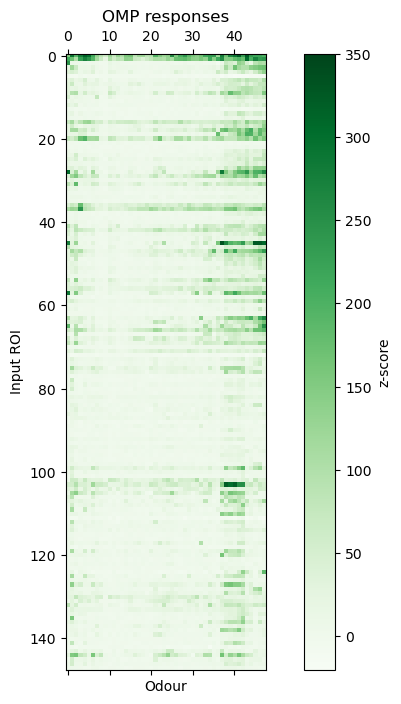

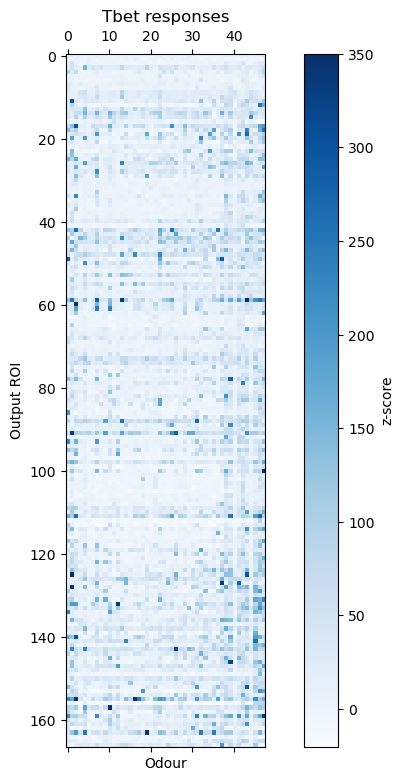

In [ ]:
# All OMP response integrals
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.matshow(((X.T[olo,:].T)), cmap=cm.Greens,vmin=-20,vmax=350)
plt.title("OMP responses")
plt.xlabel("Odour")
plt.ylabel("Input ROI")
ax = plt.gca()
for PCM in ax.get_children():
    if isinstance(PCM, cm.ScalarMappable):
        break
cbar = plt.colorbar(PCM, ax=ax)
cbar.set_label('z-score')

# All Tbet response integrals
plt.figure(figsize=(10,9))
ax = plt.gca()
ax.matshow(((Y.T[olo,:].T)), cmap=cm.Blues,vmin=-20,vmax=350)
plt.title("Tbet responses")
plt.xlabel("Odour")
plt.ylabel("Output ROI")
ax = plt.gca()
for PCM in ax.get_children():
    if isinstance(PCM, cm.ScalarMappable):
        break
cbar = plt.colorbar(PCM, ax=ax)
cbar.set_label('z-score')

---

## Figure 3: Odour representations become decorrelated from input to output.

### Correlation matrices

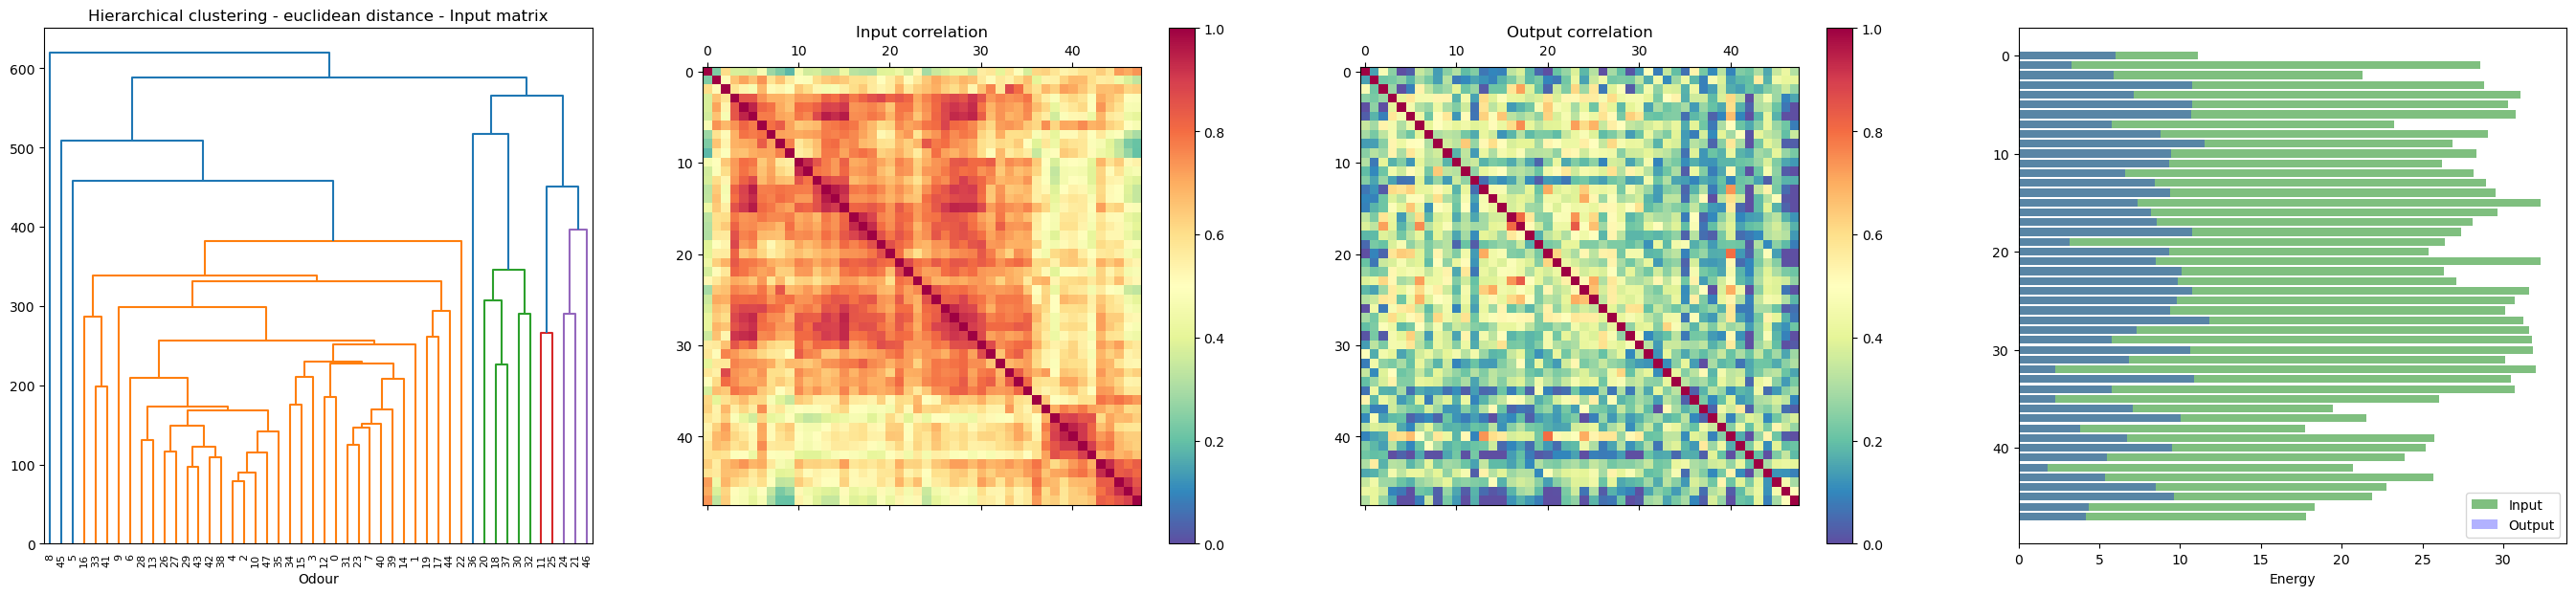

In [ ]:
# Correlation matrices INPUT CLUSTERING
input_data = X.T
output_data = Y.T
sim_fun = np.corrcoef

plt.figure(figsize=(34,7))
plt.subplot(1,4,1)
Z = H.linkage(input_data, 'weighted', metric= "euclidean", optimal_ordering = True)
H.dendrogram(Z); plt.title('Hierarchical clustering - euclidean distance - Input matrix'); plt.xlabel('Odour')
olo = H.leaves_list(Z)

plt.subplot(1,4,2); plt.matshow(sim_fun(input_data)[olo,:][:,olo], cmap = cm.Spectral_r, fignum=False, vmin= 0, vmax=1); plt.title("Input correlation")
plt.colorbar()
plt.subplot(1,4,3); plt.matshow(sim_fun(output_data)[olo,:][:,olo], cmap = cm.Spectral_r, fignum=False, vmin= 0, vmax=1); plt.title("Output correlation")
plt.colorbar()

# Energy of correlations across odours
CC_in_energy = []
CC_out_energy = []
CC_in  = sim_fun((input_data)[olo,:][:,olo])
CC_out = sim_fun((output_data)[olo,:][:,olo])

for n in range(X.shape[1]):
    b = sum(CC_in[n]**2)-1
    c = sum(CC_out[n]**2)-1
    CC_in_energy.append(b)
    CC_out_energy.append(c)

bar_x = list(range((len(tbet_odours)-1) +1))
plt.subplot(1,4,4); 
plt.barh(bar_x,CC_in_energy, alpha=0.5, label=f"Input", color='green')
plt.barh(bar_x,CC_out_energy, alpha=0.3, label=f"Output", color='blue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Energy')
plt.show()

### Correlation energy and response variance

Correlation energy comparison (t-test): p = 3.4224384254814435e-42
Input correlation energy - Mean: 26.797, SD: 4.691
Output correlation energy - Mean: 7.703, SD: 2.684
Response variance comparison (t-test): p = 0.084
Input response variance - Mean: 1308.424, SD: 1097.610
Output response variance - Mean: 1737.528, SD: 1278.880


C:\Users\tobia\AppData\Local\Temp\ipykernel_32072\3793365095.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot1 = plt.boxplot(data,
C:\Users\tobia\AppData\Local\Temp\ipykernel_32072\3793365095.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot1 = plt.boxplot(data,


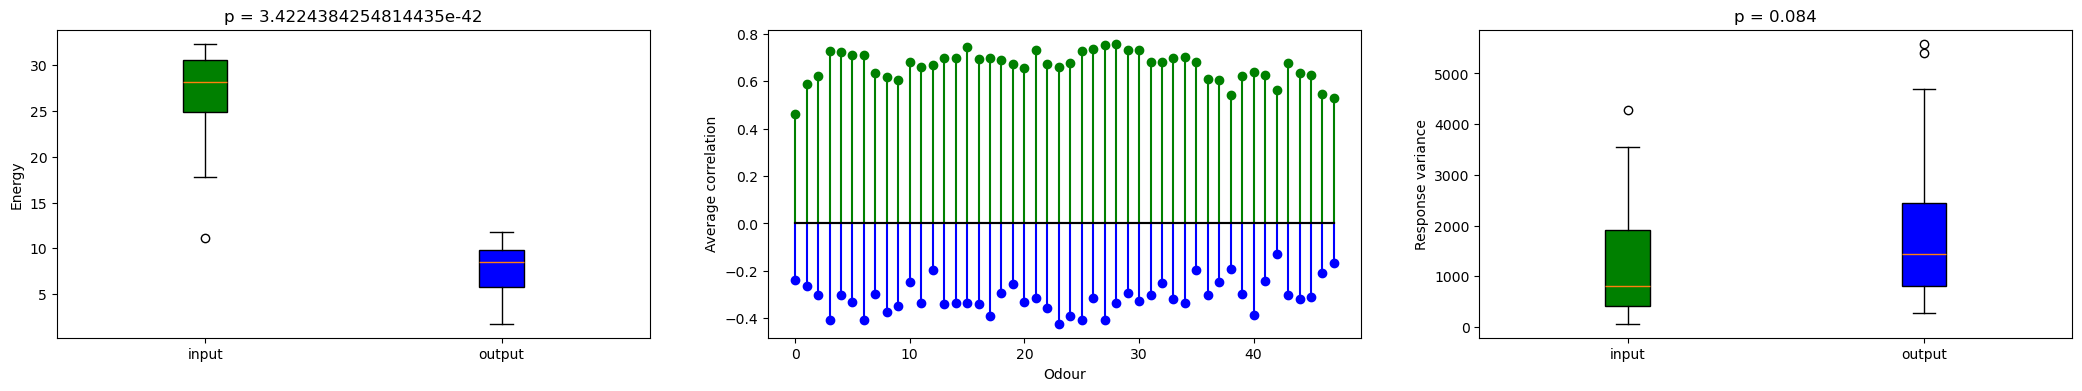

In [ ]:
# Correlation energy of correlation across odours
plt.figure(figsize=(26,4))
plt.subplot(1,3,1)
data = [CC_in_energy, CC_out_energy]
[t,p] = scipy.stats.ttest_ind(CC_in_energy, CC_out_energy)
print(f"Correlation energy comparison (t-test): p = {p}")
colors = ['green', 'blue']
tick_labels = ['input', 'output']

bplot1 = plt.boxplot(data,
                     vert=True,
                     patch_artist=True,
                     labels=tick_labels)
for bplot in (bplot1):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
plt.ylabel('Energy')
plt.title(f'p = {p}')
print(f"Input correlation energy - Mean: {mean(CC_in_energy):.3f}, SD: {std(CC_in_energy):.3f}")
print(f"Output correlation energy - Mean: {mean(CC_out_energy):.3f}, SD: {std(CC_out_energy):.3f}")

# Average correlation
corr_in, corr_out = [sim_fun(input_data), sim_fun(output_data)]
corr_in_sum, corr_out_sum = [np.mean((corr_in),0), np.mean((corr_out),0)] 
corr_in_sum = corr_in_sum[olo]
corr_out_sum = corr_out_sum[olo]*-1

corr_in_sum = corr_in_sum.tolist()
corr_out_sum = corr_out_sum.tolist()

plt.subplot(1,3,2)
scatter_x = list(range(0, 48))
markerline, stemlines, baseline = matplotlib.pyplot.stem(scatter_x, corr_in_sum, linefmt='green'); plt.ylabel('Average correlation'); plt.xlabel('Odour')
markerline.set_markerfacecolor('green')
markerline.set_markeredgecolor('green')
baseline.set_color('black')
markerline, stemlines, baseline = matplotlib.pyplot.stem(scatter_x, corr_out_sum, linefmt='blue'); plt.ylabel('Average correlation'); plt.xlabel('Odour')
markerline.set_markerfacecolor('blue')
markerline.set_markeredgecolor('blue')
baseline.set_color('black')

# Response variance
var_in = np.cov(X.T)
var_out = np.cov(Y.T)
var_in.shape

pattern_vars_in = np.diag(var_in)
pattern_vars_out = np.diag(var_out)

plt.subplot(1,3,3)
data = [pattern_vars_in, pattern_vars_out]
[t,p] = scipy.stats.ttest_ind(pattern_vars_in, pattern_vars_out)
print(f"Response variance comparison (t-test): p = {p:.3f}")
colors = ['green', 'blue']
labels = ['input', 'output']
bplot1 = plt.boxplot(data,
                     vert=True,
                     patch_artist=True,
                     labels=labels)
for bplot in (bplot1):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
plt.ylabel('Response variance')
plt.title(f'p = {p:.3f}')
print(f"Input response variance - Mean: {mean(pattern_vars_in):.3f}, SD: {std(pattern_vars_in):.3f}")
print(f"Output response variance - Mean: {mean(pattern_vars_out):.3f}, SD: {std(pattern_vars_out):.3f}")
plt.show()

### Dimensionality of Odour Responses

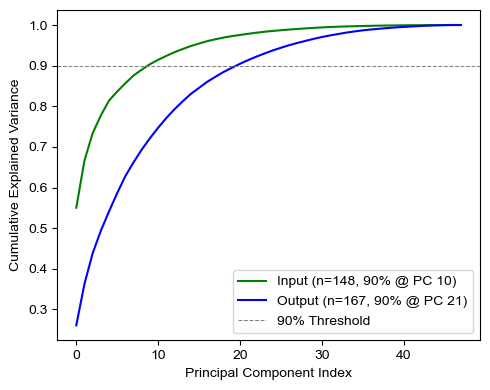

In [ ]:
pca_in = PCA()
pca_out = PCA()

pca_in.fit(X.T)
pca_out.fit(Y.T)

cum_var_input = np.cumsum(pca_in.explained_variance_ratio_)
cum_var_out = np.cumsum(pca_out.explained_variance_ratio_)

# Set font to Arial/Helvetica
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']


cum_var_input = np.cumsum(pca_in.explained_variance_ratio_)
cum_var_output = np.cumsum(pca_out.explained_variance_ratio_)

n_components_input = np.argmax(cum_var_input >= 0.9) + 1
n_components_output = np.argmax(cum_var_output >= 0.9) + 1

plt.figure(figsize=(5, 4))
plt.plot(cum_var_input, label=f'Input (n={len(X)}, 90% @ PC {n_components_input})', color='green')
plt.plot(cum_var_output, label=f'Output (n={len(Y)}, 90% @ PC {n_components_output})', color='blue')
plt.axhline(0.9, color='gray', linestyle='--', linewidth=0.75, label='90% Threshold')
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.tight_layout()
plt.show()

### Decorrelation over time: sliding window

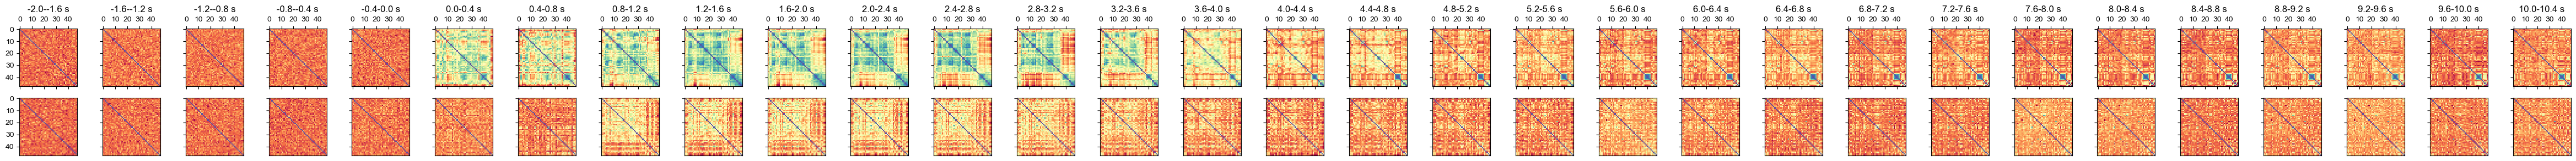

In [13]:
fig, axs = plt.subplots(2,n_wins, figsize=(60,3))
plt.subplots_adjust(hspace=0.2)
for windows in range(n_wins):
    axs[0,windows].matshow(np.corrcoef(X_sliding[windows])[olo,:][:,olo], cmap = cm.Spectral_r)
    axs[0,windows].set_title(f'{win_title[windows]:.1f}-{win_title[windows]+win_size/10:.1f} s')
    axs[1,windows].matshow(np.corrcoef(Y_sliding[windows])[olo,:][:,olo], cmap = cm.Spectral_r)
    axs[1,windows].get_xaxis().set_visible(False)
for ax in axs.flat:
    ax.label_outer()

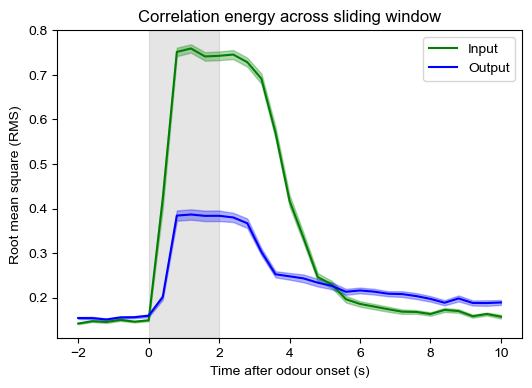

In [ ]:
# Energy of responses for sliding window
CC_in_sliding = []
CC_out_sliding = []
CC_in_sliding_energy = []
CC_out_sliding_energy = []

for windows in range(n_wins):
    CC_in1  = np.corrcoef(X_sliding[windows][olo,:][:,olo])
    CC_in_sliding.append(CC_in1)
    CC_out1 = np.corrcoef(Y_sliding[windows][olo,:][:,olo])
    CC_out_sliding.append(CC_out1)

# divide by number of odours to push between 0 and 1
for windows in range(n_wins):
    for n in range(len(X_sliding[0])):
        CC_in_energy1 = sqrt((sum(CC_in_sliding[windows][n]**2)-1) / (len(odour_inds)-1))
        CC_in_sliding_energy.append(CC_in_energy1)
        CC_out_energy1 = sqrt((sum(CC_out_sliding[windows][n]**2)-1) / (len(odour_inds)-1))
        CC_out_sliding_energy.append(CC_out_energy1)

CC_in_energy2 = np.reshape(CC_in_sliding_energy, (n_wins,len(X_sliding[0])))
CC_out_energy2 = np.reshape(CC_out_sliding_energy, (n_wins,len(X_sliding[0])))

CC_in_sliding_energy_mean = np.mean(CC_in_energy2, axis=1)
CC_out_sliding_energy_mean = np.mean(CC_out_energy2, axis=1)

label_format = '{:,.2f}'
xlabels = np.array(win_title)

plt.figure(figsize=(6,4))
plt.axvspan(0,2, color='grey',alpha=0.2)
plt.plot(xlabels, CC_in_sliding_energy_mean, 'green', label='Input')
error_in = scipy.stats.sem(CC_in_energy2,axis=1)
plt.fill_between(xlabels, CC_in_sliding_energy_mean-error_in, CC_in_sliding_energy_mean+error_in, alpha=0.3, color='green')
plt.plot(xlabels, CC_out_sliding_energy_mean, 'blue', label='Output')
error_out = scipy.stats.sem(CC_out_energy2,axis=1)
plt.fill_between(xlabels, CC_out_sliding_energy_mean-error_out, CC_out_sliding_energy_mean+error_out, alpha=0.3, color='blue')
plt.legend(loc='upper right')
plt.ylabel('Root mean square (RMS)')
plt.xlabel('Time after odour onset (s)')
plt.title('Correlation energy across sliding window')
plt.show()

---

## Figure 4: Odour identity is more accurately decoded from output than input activity.

In [15]:
# Reshape response integrals for input and output 
print(Xtrialzi_svm.shape)
#sort by clustered input
Xtrialzi_svm_sort = Xtrialzi_svm[:,olo,:]
Xtrialzi_svm_reshape = reshape(Xtrialzi_svm_sort, [len(Xtrialzi_svm_sort), -1])
print(Xtrialzi_svm_reshape.shape)

print(Ytrialzi_svm.shape)
Ytrialzi_svm_sort = Ytrialzi_svm[:,olo,:]
Ytrialzi_svm_reshape = reshape(Ytrialzi_svm_sort, [len(Ytrialzi_svm_sort), -1])
print(Ytrialzi_svm_reshape.shape)

(148, 48, 20)
(148, 960)
(167, 48, 20)
(167, 960)


In [16]:
# Create odour labels for SVM
odours_list = range(1,len(odour_inds)+1)
odours_list_repeat = repeat(odours_list, Ytrialzi_svm[0,2].shape)
odours_list_repeat_for_shuffle = repeat(odours_list, Ytrialzi_svm[0,2].shape)

print(odours_list)
print(odours_list_repeat.shape)

range(1, 49)
(960,)


In [ ]:
# Shuffle features list
def shuffle(arr): 
    random.shuffle(arr) 
    return arr 
odours_list_repeat_shuffle = shuffle(odours_list_repeat_for_shuffle)

In [18]:
def classifier(X,y):
    clf = svm.LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=0.0001, C=0.01, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=100000)
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.4, random_state=0)

    train_scores, test_scores, confusion_matrices = [],[],[]

    for ind_train, ind_test in sss.split(X, y):
        X_train = X[ind_train]
        y_train = y[ind_train]
        clf.fit(X_train, y_train)
        X_test  = X[ind_test]
        y_test  = y[ind_test]
        clf.score(X_test, y_test)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))
        y_pred =  clf.predict(X_test)
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        # print(confusion_matrices)
        
    cm = array(confusion_matrices).sum(axis=0)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)

    test_scores        = array(test_scores)
    train_scores       = array(train_scores)
    return train_scores, test_scores, cm_normalized

In [ ]:
input_data = Xtrialzi_svm_reshape.T
output_data = Ytrialzi_svm_reshape.T

odours_list_classifier = odours_list_repeat 
odours_list_classifier_shuffle = odours_list_repeat_shuffle

train_scores_input,test_scores_input, confusion_matrices_input = classifier(input_data,odours_list_classifier)  
train_scores_input_shuffle,test_scores_input_shuffle, confusion_matrices_input_shuffle = classifier(input_data,odours_list_classifier_shuffle)  
train_scores_output,test_scores_output, confusion_matrices_output = classifier(output_data,odours_list_classifier)  
train_scores_output_shuffle,test_scores_output_shuffle, confusion_matrices_output_shuffle = classifier(output_data,odours_list_classifier_shuffle)  

print("Input: %0.3f accuracy with a standard deviation of %0.3f" % (test_scores_input.mean(), test_scores_input.std()))
print("Input shuffled: %0.3f accuracy with a standard deviation of %0.3f" % (test_scores_input_shuffle.mean(), test_scores_input_shuffle.std()))
print("Output: %0.3f accuracy with a standard deviation of %0.3f" % (test_scores_output.mean(), test_scores_output.std()))
print("Output shuffled: %0.3f accuracy with a standard deviation of %0.3f" % (test_scores_output_shuffle.mean(), test_scores_output_shuffle.std()))

Input: 0.941 accuracy with a standard deviation of 0.008
Input shuffled: 0.024 accuracy with a standard deviation of 0.007
Output: 0.995 accuracy with a standard deviation of 0.004
Output shuffled: 0.018 accuracy with a standard deviation of 0.007


### Classifier with increasing number of ROIs

In [20]:
X_input = Xtrialzi_svm_reshape.T
X_output = Ytrialzi_svm_reshape.T
y = odours_list_repeat
y_shuffle = odours_list_repeat_shuffle

n_runs = 2 # Number of runs

maxROIs_input = X_input.shape[1]
maxROIs_output = X_output.shape[1]
numROIs_input = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,maxROIs_input]
numROIs_output = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,maxROIs_output]

acc_input = []
acc_input_shuffle = []
acc_output = []
acc_output_shuffle = []

for n in numROIs_input:
    this_acc_input = []
    this_acc_input_shuffle = []
    
    for i in range(n_runs):
        which_ROIs = np.random.choice(maxROIs_input,n,replace=False)
        train_acc_input, test_acc_input, conf_matrix_input = classifier(X_input[:,which_ROIs],y)
        this_acc_input.append(mean(test_acc_input))
        train_acc_input_shuffle, test_acc_input_shuffle, conf_matrix_input_shuffle = classifier(X_input[:,which_ROIs],y_shuffle)
        this_acc_input_shuffle.append(mean(test_acc_input_shuffle))        
    
    acc_input.append(this_acc_input)
    acc_input_shuffle.append(this_acc_input_shuffle)   

for n in numROIs_output:
    this_acc_output = []
    this_acc_output_shuffle = []
    
    for i in range(n_runs):
        which_ROIs = np.random.choice(maxROIs_output,n,replace=False)
        train_acc_output, test_acc_output, conf_matrix_output = classifier(X_output[:,which_ROIs],y)
        this_acc_output.append(mean(test_acc_output))
        train_acc_output_shuffle, test_acc_output_shuffle, conf_matrix_output_shuffle = classifier(X_output[:,which_ROIs],y_shuffle)
        this_acc_output_shuffle.append(mean(test_acc_output_shuffle))        

    acc_output.append(this_acc_output)
    acc_output_shuffle.append(this_acc_output_shuffle)

(0.0, 1.0)

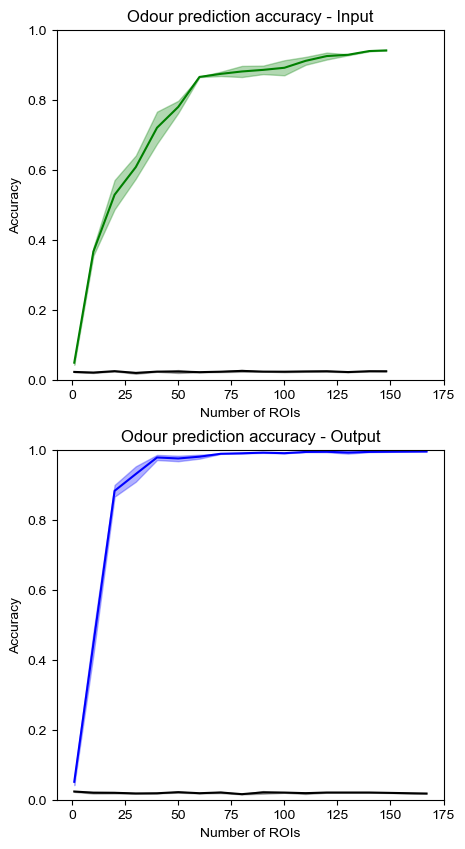

In [ ]:
# Plot classifier with increasing ROIs

acc_input = np.array(acc_input)
acc_input_shuffle = np.array(acc_input_shuffle)
acc_output = np.array(acc_output)
acc_output_shuffle = np.array(acc_output_shuffle)

mean_acc_input = mean(acc_input,axis=1)
mean_acc_input_shuffle = mean(acc_input_shuffle,axis=1)
mean_acc_output = mean(acc_output,axis=1)
mean_acc_output_shuffle = mean(acc_output_shuffle,axis=1)

plt.figure(figsize=(5,10))
ax1 = plt.subplot(2,1,1)
plt.plot(numROIs_input,mean_acc_input,color='green')
error = std(acc_input,axis=1)
plt.fill_between(numROIs_input, mean_acc_input-error, mean_acc_input+error,alpha=0.3,color='green')
plt.plot(numROIs_input,mean_acc_input_shuffle,color='black')
error_shuffle = std(acc_input_shuffle,axis=1)
plt.fill_between(numROIs_input, mean_acc_input_shuffle-error_shuffle, mean_acc_input_shuffle+error_shuffle,alpha=0.3, color='black')
plt.title('Odour prediction accuracy - Input')
plt.xlabel('Number of ROIs')
plt.ylabel('Accuracy')
plt.ylim(0,1.0) 

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(numROIs_output,mean_acc_output,color='blue')
error = std(acc_output,axis=1)
plt.fill_between(numROIs_output, mean_acc_output-error, mean_acc_output+error,alpha=0.3,color='blue')
plt.plot(numROIs_output,mean_acc_output_shuffle,color='black')
error_shuffle = std(acc_output_shuffle,axis=1)
plt.fill_between(numROIs_output, mean_acc_output_shuffle-error_shuffle, mean_acc_output_shuffle+error_shuffle,alpha=0.3, color='black')
plt.title('Odour prediction accuracy - Output')
plt.xlabel('Number of ROIs')
plt.ylabel('Accuracy')
plt.ylim(0,1.0)

### Difference in prediction accuracy for input and output

In [22]:
# Use random selection of glomeruli

X_input = Xtrialzi_svm_reshape.T
X_output = Ytrialzi_svm_reshape.T
y = odours_list_repeat

maxROIs_input = X_input.shape[1]
maxROIs_output = X_output.shape[1]

numROIs_input = [30]
numROIs_output = [30]

acc_input = []
acc_output = []

this_acc_input = []
which_ROIs = np.random.choice(maxROIs_input, size=numROIs_input,replace=False)
train_acc_input, test_acc_input, conf_matrix_input = classifier(X_input[:,which_ROIs],y)  

which_ROIs = np.random.choice(maxROIs_output, size=numROIs_output,replace=False)
train_acc_output, test_acc_output, conf_matrix_output = classifier(X_output[:,which_ROIs],y)      

print("Input: %0.3f accuracy with a standard deviation of %0.3f" % (test_acc_input.mean(), test_acc_input.std()))
print("Output: %0.3f accuracy with a standard deviation of %0.3f" % (test_acc_output.mean(), test_acc_output.std()))

Input: 0.619 accuracy with a standard deviation of 0.019
Output: 0.952 accuracy with a standard deviation of 0.009


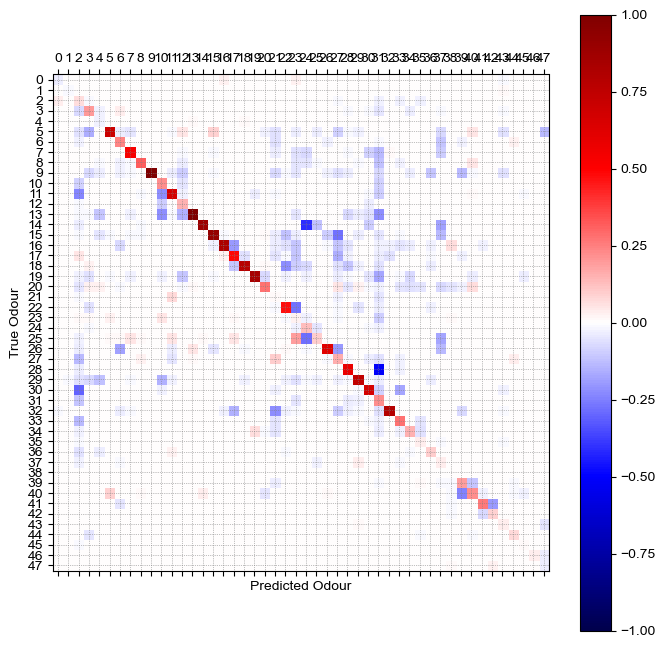

In [23]:
# Plot difference of confusion matrices

diff_cm = conf_matrix_output - conf_matrix_input
odours = tbet_odours
colmap = cm.seismic
fig, ax =plt.subplots(nrows=1, ncols=1,figsize=(8,8))
ax.matshow(diff_cm, cmap=colmap, vmin=-1,vmax=1)
gca().set_yticks(arange(len(odours)))
gca().set_xticks(arange(len(odours)))
xlabel("Predicted Odour"); ylabel("True Odour"); 
grid(True, color="gray", linestyle=":", linewidth=0.5)

for PCM in ax.get_children():
    if isinstance(PCM, mpl.cm.ScalarMappable):
        break
cbar = plt.colorbar(PCM, ax=ax)